Learn iterator for thermal problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from feanet.iterator import PsiNet
from feanet.iterator import PsiIterator
from data.dataset import MechanicalDataSet

Create plots for convergence test

In [2]:
N = [2**1+1, 2**2+1, 2**3+1, 2**4+1, 2**5+1, 2**6+1, 2**7+1, 2**8+1, 2**9+1]
q_v11 = [0.11111110105447959, 0.20320289267157887, 0.22705374241213908, 0.23623111562228755, 
         0.2521629576411248, 0.25900978515692, 0.26230444531364716, 0.26295500430251095, 0.26316125814795244]
q_jac = [0.33333329777930615, 0.7357023129437866, 0.9258110664371474, 0.9809080721911905, 0.9809080721911905, 
         0.9987957479351752, 0.9996457255615815, 0.9996247757202597, 0.9996247757202597]

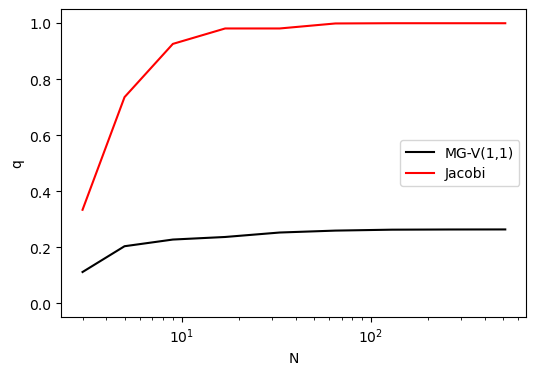

In [3]:
plt.figure(figsize=(6, 4))
plt.plot(N, q_v11, label='MG-V(1,1)', c='k')
plt.plot(N, q_jac, label='Jacobi', c='r')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('N')
plt.ylabel('q')
plt.legend(loc='center right')
plt.ylim([-0.05, 1.05])
plt.savefig('results/q_compare.png', dpi=500, bbox_inches='tight')

In [4]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
n_elem = 2**5 # element size on the edge
nb_layers = 3
bs = 5

no_neumann = True # not considering Neumann bc
train = False # True or False
model_name = 'dirich_33x33_smoother'
model_dir = 'model/learn_iterator/thermal'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [6]:
training_set = MechanicalDataSet('data/data_thermal/dirich_plate_train_33x33.h5', device)
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
elem_mask_train, node_mask_train, dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, neumann_conn_train, material_train, f_train, u_train = next(iter(train_dataloader))

test_set = MechanicalDataSet('data/data_thermal/neumann_plate_test_33x33.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))

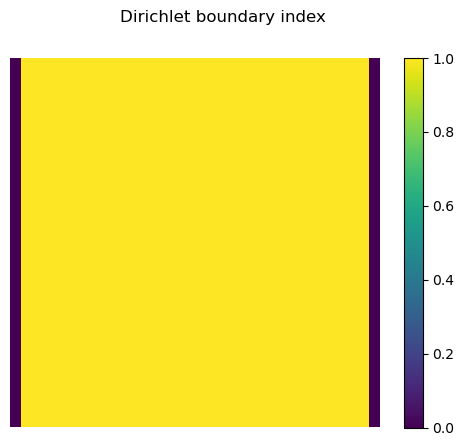

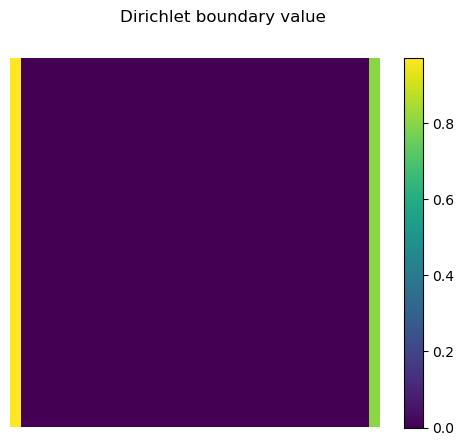

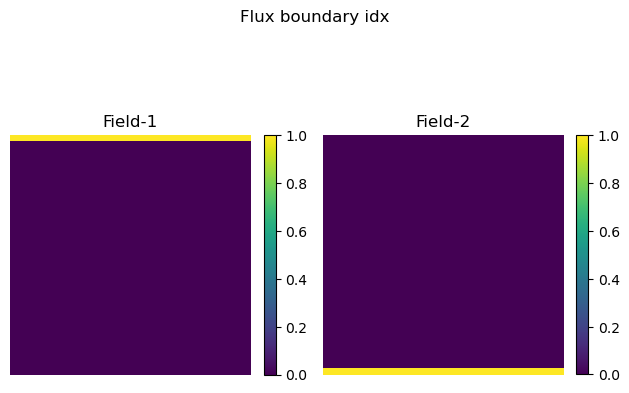

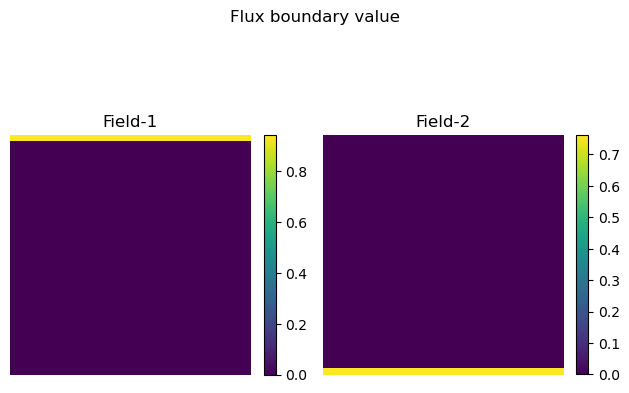

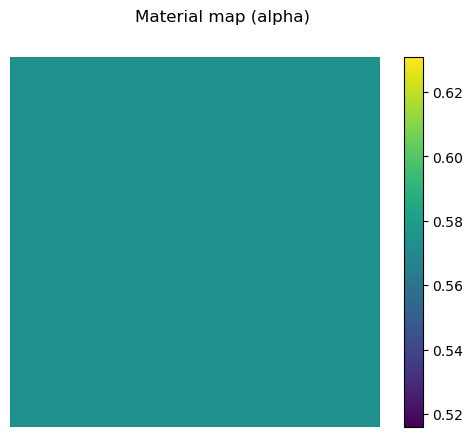

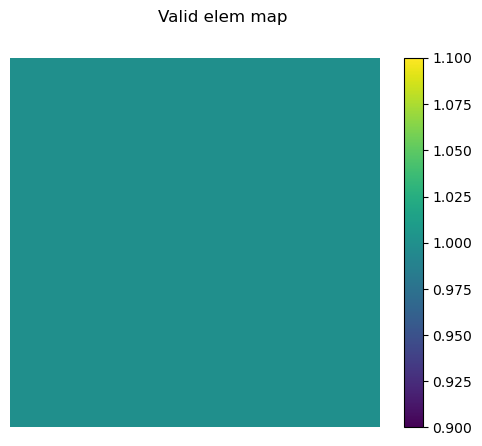

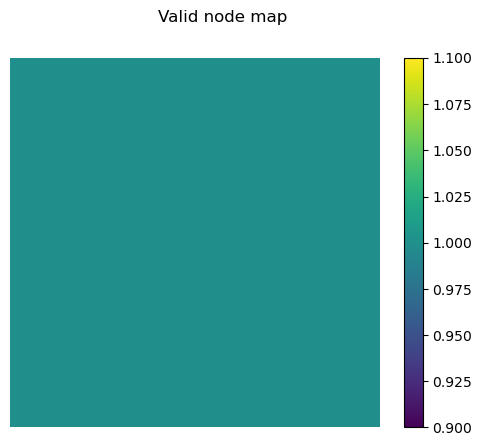

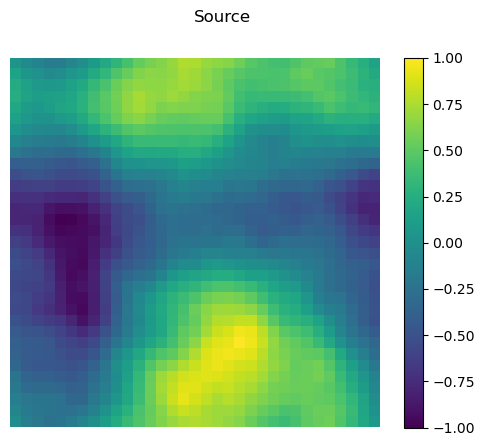

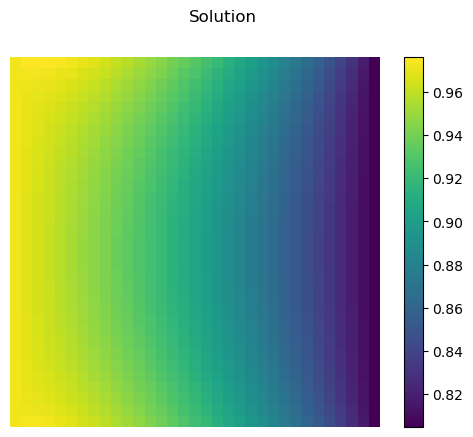

In [7]:
k = 0 # the index of test data to be shown
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Flux boundary idx')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

Create a set of solution data for testing purpose

In [8]:
solution_test, rhs_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

In [9]:
hsize = 2e-3 # m
ku, kf = 1, 1
grid = SingleGrid(hsize, n_elem=n_elem, mode='thermal', dev=device_predict, no_neumann=no_neumann)

0 0.6352805841310315
1 0.3551347988779985
2 0.2573207010311344
3 0.20559854556081641
4 0.17303732087187457
5 0.15042148150679635
6 0.13368369101213298
7 0.12073238999440425
8 0.11037502173918637
9 0.10187874604699479
10 0.09476682871975499
11 0.08871491098284941
12 0.08349415211207387
13 0.07893818819937014
14 0.07492298953373697
15 0.07135408054238386
16 0.06815815153706166
17 0.06527739029487363
18 0.06266555337757787
19 0.060285182079408445
20 0.05810559036547847
21 0.056101385050529626
22 0.05425136020171636
23 0.05253765934756859
24 0.05094513241914813
25 0.04946083635546441
26 0.048073643108492166
27 0.04677392891578255
28 0.045553325755473155
29 0.04440452087139735
30 0.043321093812968975
31 0.04229738301072281
32 0.04132837579606866
33 0.04040961717207021
34 0.03953713368833957
35 0.0387073695635139
36 0.037917132801196456
37 0.037163549508208514
38 0.03644402498261925
39 0.03575621041882938
40 0.03509797429679485
41 0.03446737769627686
42 0.0338626529152408
43 0.03328218488208

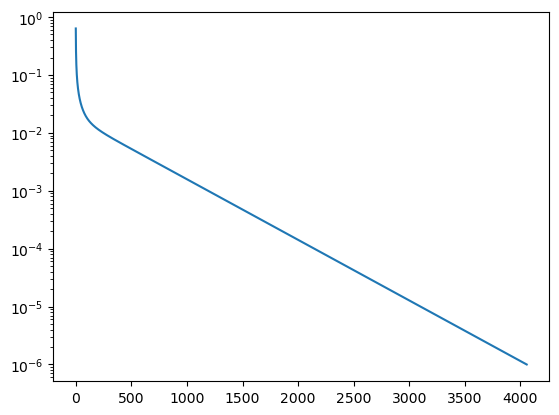

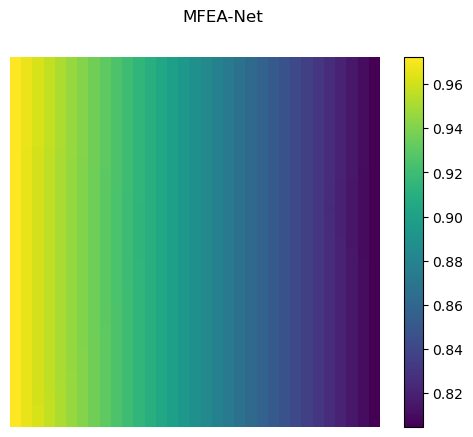

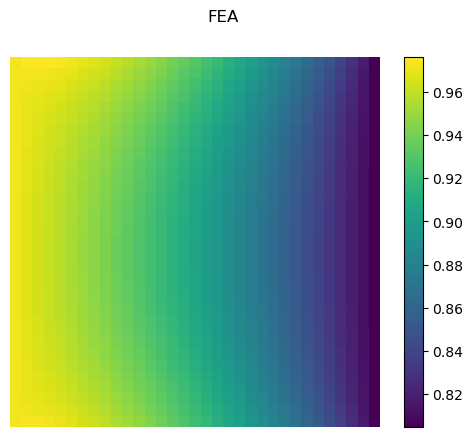

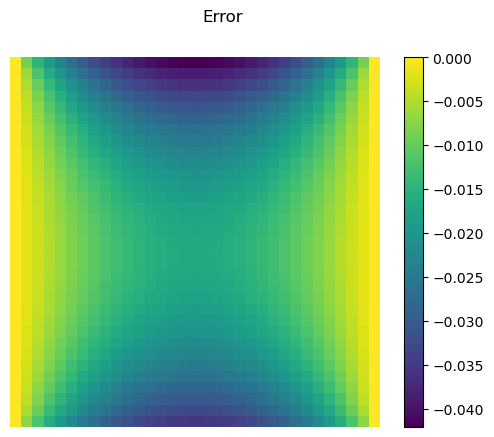

In [10]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(True):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test)
        residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_thermalfield(jacu_test[0], "MFEA-Net")
    plot.plot_thermalfield(solution_test[0], "FEA")
    plot.plot_thermalfield(jacu_test[0]-solution_test[0], 'Error')

In [11]:
max_epochs = 1000

if(train):
    my_iterator = PsiIterator(device, hsize, n_elem, no_neumann, batch_size=bs, mode='thermal', iterator='psi', nb_layers=nb_layers, max_epochs=max_epochs)
    loss_train = torch.zeros((max_epochs, 1))
    loss_train = my_iterator.Train(training_set, model_name, model_dir)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


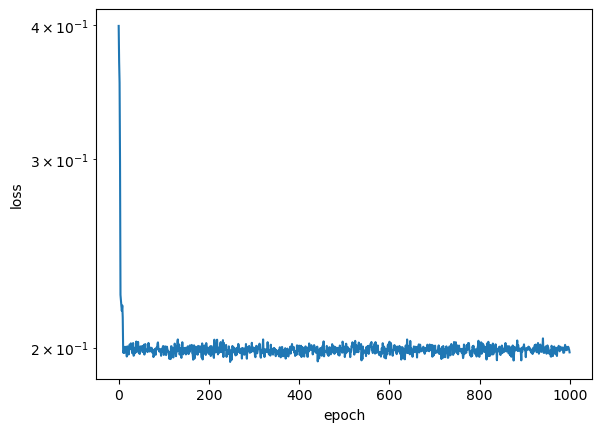

In [12]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, hsize, n_elem, no_neumann, psi_net=my_net, grid=grid, nb_layers=nb_layers, batch_size=1, iterator='psi')
my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

In [13]:
list(my_net.parameters())

[Parameter containing:
 tensor([[[[-0.2123, -0.0335, -0.1305],
           [-0.4624, -1.0278, -0.0401],
           [-0.2198, -0.0409, -0.1365]]]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[-0.1414, -0.1788, -0.2739],
           [-0.1422,  0.1062, -0.7521],
           [-0.1460, -0.1826, -0.2795]]]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[0.1495, 0.2918, 0.1406],
           [0.5748, 0.1638, 0.0724],
           [0.1504, 0.2931, 0.1441]]]], dtype=torch.float64, requires_grad=True)]

0 0.6352805841310315
1 0.12337316762263636
2 0.061618229977338464
3 0.044911533927236465
4 0.036140649562802156
5 0.030593389994821276
6 0.02672529837718745
7 0.02386662086223042
8 0.021671825558398358
9 0.019938364520914735
10 0.0185366923415249
11 0.017379358174594503
12 0.016405374232639627
13 0.015571314135507665
14 0.014845781635131197
15 0.014205777715730065
16 0.013634236871250236
17 0.013118326524354318
18 0.012648261571595041
19 0.012216472837692428
20 0.011817020745331835
21 0.01144517952612563
22 0.011097140254356484
23 0.01076979680636503
24 0.010460589845852927
25 0.010167391590014818
26 0.009888419427034369
27 0.009622170132698152
28 0.009367368967448277
29 0.00912292967488774
30 0.00888792259469269
31 0.00866154891912656
32 0.00844311968219752
33 0.008232038456048649
34 0.008027786996522488
35 0.007829913267087658
36 0.007638021403184076
37 0.007451763274838911
38 0.007270831375758255
39 0.007094952819798201
40 0.0069238842659956
41 0.006757407624743162
42 0.006595326422

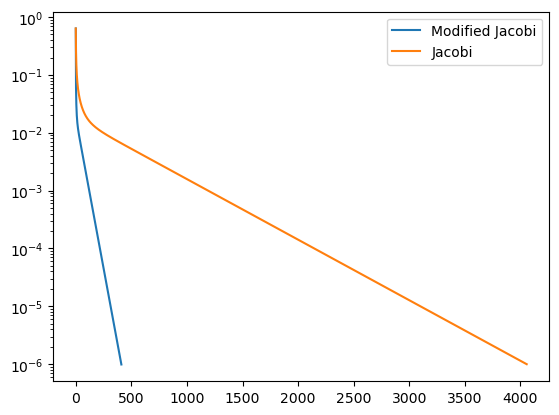

In [14]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS):
        u_test = new_iterator.PsiRelax(u_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test, 1)
        residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

In [15]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

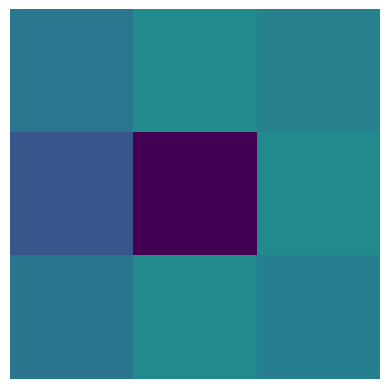

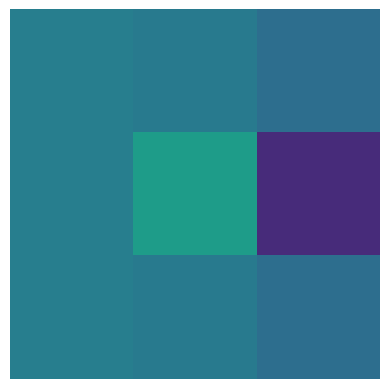

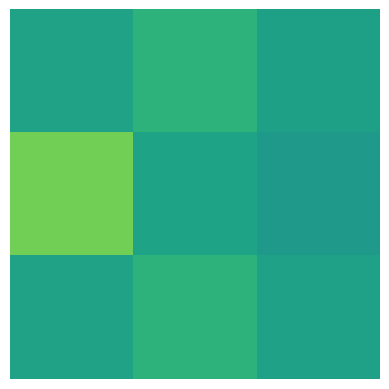

In [16]:
# plot the kernels
mlist = list(my_net.cpu().parameters())
heatmap2d(mlist[0].view(3,3).detach().numpy(),fname='results/kernel1.jpg', cbar=False)
heatmap2d(mlist[1].view(3,3).detach().numpy(),fname='results/kernel2.jpg', cbar=False)
heatmap2d(mlist[2].view(3,3).detach().numpy(),fname='results/kernel3.jpg', cbar=False)

In [17]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [18]:
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)

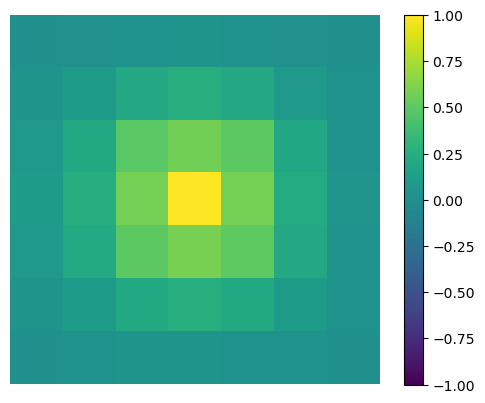

In [19]:
heatmap2d(kernel2.view(7,7).detach().numpy(),fname='results/kernel_comb.jpg')

In [20]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(hsize, n, no_neumann, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


RuntimeError: Given groups=1, weight of size [1, 1, 1, 1], expected input[1, 2, 33, 33] to have 1 channels, but got 2 channels instead

In [ ]:
with torch.no_grad():
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 6.110549691121599
1 0.40349303552428445
2 0.03253253526036652
3 0.0026649648955013277
4 0.00022204865784785198
5 1.895246564700488e-05
6 1.666710196088509e-06
7 1.5148893180103602e-07
Solution converges after 7 Psi-Jacobi multigrid iterations in 0.07870268821716309 seconds.


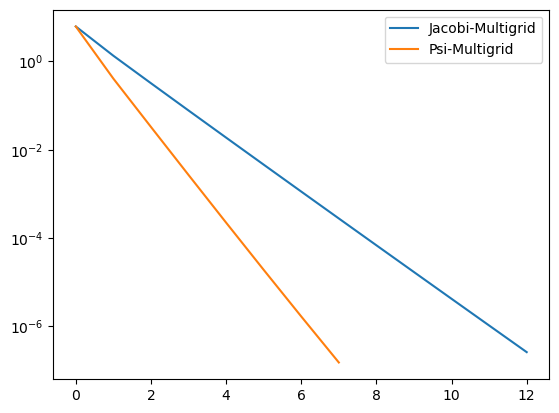

In [ ]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

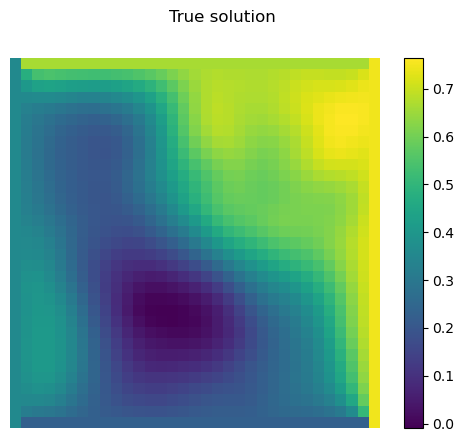

In [ ]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

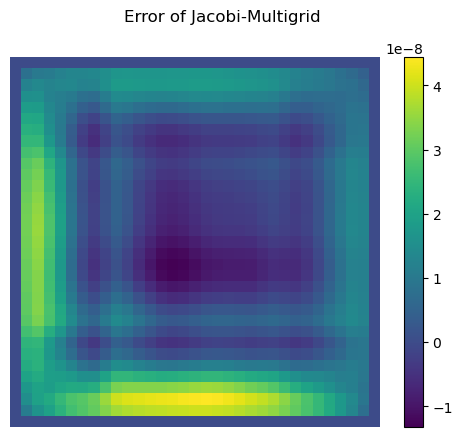

In [ ]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

In [ ]:
u_mg_jac-solution_test

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 7.9839e-09, 1.0146e-08,  ..., 6.7189e-09,
           4.5821e-09, 0.0000e+00],
          [0.0000e+00, 1.2337e-08, 1.3741e-08,  ..., 7.9841e-09,
           6.2370e-09, 0.0000e+00],
          ...,
          [0.0000e+00, 1.5265e-08, 1.9797e-08,  ..., 1.3900e-08,
           9.2911e-09, 0.0000e+00],
          [0.0000e+00, 1.1066e-08, 1.6371e-08,  ..., 1.3201e-08,
           7.9108e-09, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]]], device='cuda:0', dtype=torch.float64)

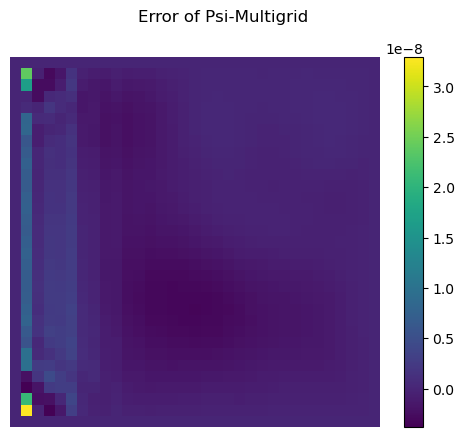

In [ ]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')

In [ ]:
u_mg_psi.detach()-solution_test

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  2.3956e-08, -4.3712e-10,  ...,  1.0531e-10,
            8.7275e-11,  0.0000e+00],
          [ 0.0000e+00,  1.6815e-08, -2.6341e-09,  ...,  1.8766e-10,
            1.2829e-10,  0.0000e+00],
          ...,
          [ 0.0000e+00,  2.0902e-08, -2.3621e-09,  ..., -3.1898e-10,
           -1.8509e-10,  0.0000e+00],
          [ 0.0000e+00,  3.2883e-08, -1.2684e-10,  ..., -1.5846e-10,
           -9.8735e-11,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float64)